In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from monte_carlo import monte_carlo
from bs import BlackScholes

# Пример вычисления цен


In [2]:
# Arguments

S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2
alpha = 0.8
N = 5_000_000

# Calculate prices

price_call, _ = monte_carlo(S0, K, T, r, sigma, alpha, N, call=True)
price_put, _ = monte_carlo(S0, K, T, r, sigma, alpha, N, call=False)
print(f'(CALL) Monte-Carlo method (alpha = {alpha}) price = {price_call:.4f}')
print(f'(PUT) Monte-Carlo method (alpha = {alpha}) price = {price_put:.4f}\n')

alpha_classic = 1.0
price_classic_call, _ = monte_carlo(
    S0, K, T, r, sigma, alpha_classic, N, call=True)
price_classic_put, _ = monte_carlo(
    S0, K, T, r, sigma, alpha_classic, N, call=False)
print(
    f'(CALL) Monte-Carlo method (alpha = {alpha_classic}) price = {price_classic_call:.4f}')
print(
    f'(PUT) Monte-Carlo method (alpha = {alpha_classic}) price = {price_classic_put:.4f}\n')

model = BlackScholes(sigma, r)
print(
    f'(CALL) Analytic solution (alpha = 1.0) price = {model.call_price(S0, T, K):.4f}')
print(
    f'(PUT) Analytic solution (alpha = 1.0) price = {model.put_price(S0, T, K):.4f}\n')

(CALL) Monte-Carlo method (alpha = 0.8) price = 10.6162
(PUT) Monte-Carlo method (alpha = 0.8) price = 5.4123

(CALL) Monte-Carlo method (alpha = 1.0) price = 10.4503
(PUT) Monte-Carlo method (alpha = 1.0) price = 5.5704

(CALL) Analytic solution (alpha = 1.0) price = 10.4506
(PUT) Analytic solution (alpha = 1.0) price = 5.5735



# График зависимости цены от числа симуляций


In [3]:
n_list = [i * 20_000 for i in range(1, 400)]
prices = []

S0 = 100
K = 110
T = 1.0
r = 0.05
sigma = 0.2
alpha = 0.8

for N in n_list:
    price, _ = monte_carlo(S0, K, T, r, sigma, alpha, size=N, call=True)
    prices.append(price)

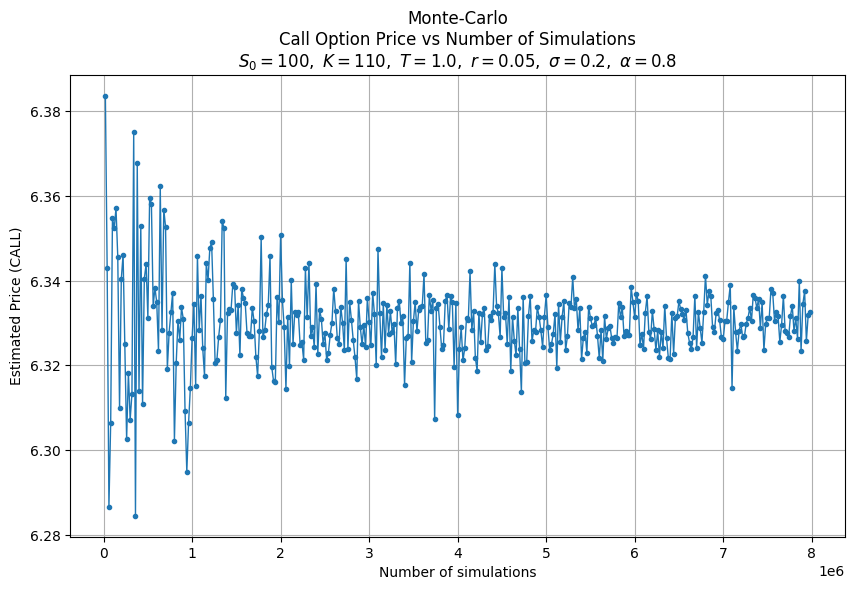

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(n_list, prices, marker='o', markersize=3, linewidth=1)
plt.title(
    f'Monte-Carlo\nCall Option Price vs Number of Simulations\n'
    f'$S_0={S0},\\ K={K},\\ T={T},\\ r={r},\\ \\sigma={sigma},\\ \\alpha={alpha}$'
)
plt.xlabel('Number of simulations')
plt.ylabel('Estimated Price (CALL)')
plt.grid(True)
plt.show()